In [1]:
# importing modules
import cv2
import numpy as np
import os
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
train_x = []
train_y = []
test_x = []
test_y = []

In [3]:
# the class of each image file can be extracted using the file name
# to do so, we can split the filename using '-' and take the item in the 0th index

file_name = os.listdir('../input/meat-freshness-image-dataset/Meat Freshness.v1-new-dataset.multiclass/train/')
names = [i.split('-')[0] for i in file_name]
set(names)

{'FRESH', 'HALF', 'SPOILED', '_classes.csv'}

In [4]:
# performing label encoding
class_label_encoding = {
    'SPOILED': 0,
    'HALF': 1,
    'FRESH': 2
}

In [5]:
train_dir = '../input/meat-freshness-image-dataset/Meat Freshness.v1-new-dataset.multiclass/train/'

for file_name in os.listdir(train_dir):
    class_name = file_name.split('-')[0]
    if(class_name == '_classes.csv'): continue # ignore the csv file
    img = cv2.imread(train_dir+file_name).astype('float32') # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) # resize the image
    img /= 255. # normalising pixel values
    train_x.append(img)
    train_y.append(class_label_encoding[class_name])

In [6]:
fresh_dir = '/kaggle/input/meat-quality-assessment-based-on-deep-learning/Fresh/'
for file_name in os.listdir(fresh_dir):
    img = cv2.imread(fresh_dir+file_name).astype('float32') # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) # resize the image
    img /= 255. # normalising pixel values
    train_x.append(img)
    train_y.append(2)

In [7]:
spoiled_dir ='/kaggle/input/meat-quality-assessment-based-on-deep-learning/Spoiled/'
for file_name in os.listdir(spoiled_dir):
    img = cv2.imread(spoiled_dir+file_name).astype('float32') # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) # resize the image
    img /= 255. # normalising pixel values
    train_x.append(img)
    train_y.append(0)

In [8]:
val_dir = '../input/meat-freshness-image-dataset/Meat Freshness.v1-new-dataset.multiclass/valid/'

for file_name in os.listdir(val_dir):
    class_name = file_name.split('-')[0]
    if(class_name == '_classes.csv'): continue # ignore the csv file
    img = cv2.imread(val_dir+file_name).astype('float32') # read the colour image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) # resize the image
    img /= 255. # normalising pixel values
    test_x.append(img)
    test_y.append(class_label_encoding[class_name])

In [9]:
print('shape of train x:', end=' ')
print(np.asarray(train_x).shape)
print('len of train y: '+ str(len(train_y)))

print('shape of test x:', end=' ')
print(np.asarray(test_x).shape)

print('len of test y: '+ str(len(test_y)))

shape of train x: (3711, 128, 128, 3)
len of train y: 3711
shape of test x: (451, 128, 128, 3)
len of test y: 451


In [10]:
# let's look at the class distribution
print('Train distribution')
print(pd.Series(train_y).value_counts())

print('Test distribution')
pd.Series(test_y).value_counts()

Train distribution
2    1623
0    1458
1     630
dtype: int64
Test distribution


2    178
1    159
0    114
dtype: int64

In [11]:
# performing train test split with stratify enabled to maintain the class distribution
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.3, random_state=42, stratify=train_y)

# free up memory
del train_x
del train_y

In [12]:
# performing one hot encoding and concerting list to numpy array before training
x_train = np.array(x_train)
x_val = np.array(x_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [13]:
model = Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3))) # each image shape - 416x416x3
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3,'softmax')) # 3 classes

model.compile('Adam','categorical_crossentropy',['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 128)       0

In [14]:
# perform data augmentation
data_generator = ImageDataGenerator(rotation_range=15, zoom_range=0.1, vertical_flip=True, width_shift_range=0.1, height_shift_range=0.1)

In [15]:
# history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128, epochs=25)
history = model.fit(data_generator.flow(x_train,y_train,batch_size=128),validation_data=data_generator.flow(x_val, y_val, batch_size=32),epochs=100,callbacks=[EarlyStopping(patience=8,restore_best_weights=True)])

Epoch 1/100
21/21 [==============================] - 22s 634ms/step - loss: 1.5060 - accuracy: 0.4255 - val_loss: 0.9960 - val_accuracy: 0.4372
Epoch 2/100
21/21 [==============================] - 13s 638ms/step - loss: 0.9768 - accuracy: 0.4524 - val_loss: 0.9106 - val_accuracy: 0.4372
Epoch 3/100
21/21 [==============================] - 13s 638ms/step - loss: 0.8923 - accuracy: 0.5229 - val_loss: 0.8428 - val_accuracy: 0.6930
Epoch 4/100
21/21 [==============================] - 13s 637ms/step - loss: 0.8713 - accuracy: 0.5279 - val_loss: 0.7538 - val_accuracy: 0.6050
Epoch 5/100
21/21 [==============================] - 14s 648ms/step - loss: 0.6420 - accuracy: 0.7178 - val_loss: 1.2199 - val_accuracy: 0.6463
Epoch 6/100
21/21 [==============================] - 13s 617ms/step - loss: 0.6975 - accuracy: 0.7031 - val_loss: 0.4938 - val_accuracy: 0.7729
Epoch 7/100
21/21 [==============================] - 13s 619ms/step - loss: 0.5213 - accuracy: 0.7790 - val_loss: 0.4195 - val_accuracy:

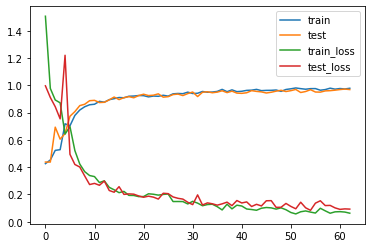

In [16]:
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.legend()
pyplot.show()

In [17]:
loss, acc = model.evaluate(np.array(test_x), to_categorical(test_y))
print('Testing accuracy on unseen data:', round(acc*100,3))
print('Testing loss on unseen data:', round(loss,3))

15/15 [==============================] - 0s 13ms/step - loss: 0.1549 - accuracy: 0.9468
Testing accuracy on unseen data: 94.678
Testing loss on unseen data: 0.155


In [18]:
model.save('trained_model.h5')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 128)       0

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [21]:
test_x1 = np.array(test_x)
print(test_x1.shape)

(451, 128, 128, 3)


In [22]:
test_gen = data_generator.flow(test_x1, test_y, batch_size=32)

In [23]:
y_pred = model.predict(test_gen)

def toClass(pred):
    
    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index
        
    return class_

cm = confusion_matrix(test_y,toClass(y_pred))



In [24]:
print(cm)

[[35 38 41]
 [30 66 63]
 [45 69 64]]


In [25]:
import matplotlib.pyplot as plt

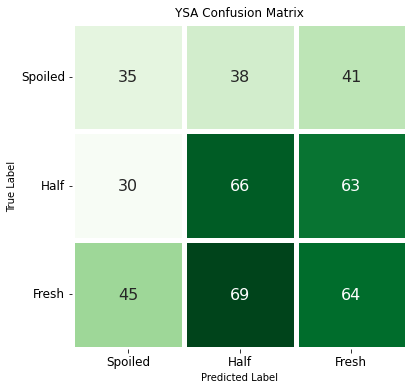

In [26]:
df1 = pd.DataFrame(columns=["Spoiled","Half","Fresh"], index= ["Spoiled","Half","Fresh"], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("YSA Confusion Matrix", size = 12)
plt.show()